# Bank Customer Churn Classification Using Neural Networks

In [319]:
# Import base modules for data manipulation and analysis
import numpy as np
import pandas as pd

# Import module for casting data type
from typing import List

# Import preprocessing modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import itertools

# Import necessary modules for logistic regression baseline model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Import necessary deep learning modules 
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

# Import all custom metrics modules for neural network
from metrics import recall_m, precision_m, f1_score

# Import modules for plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes 

# Set TensorFlow and numpy seeds
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)


In [320]:
bank_churn_df = pd.read_csv(r'C:\Users\evans\PycharmProjects\bank_churn_nn_classification\data\Churn_Modelling.csv')

## EDA (Exploratory Data Analysis)

In [321]:
bank_churn_df.shape

(10000, 14)

Our dataset has 10000 customers accounts and 14 features.

In [322]:
bank_churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [323]:
def plot_continuous_variable_distributions(data: pd.DataFrame, columns: List[str]) -> Axes:
    # Set the number of rows and columns for subplots
    num_plots = len(columns)
    num_rows = num_plots // 3 + (num_plots % 3 > 0)  # Adjust the number of rows as needed
    num_cols = min(num_plots, 3)

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
    fig.subplots_adjust(hspace=0.5)

    for i, col in enumerate(columns):
        if num_rows > 1:
            ax = axes[i // num_cols, i % num_cols]
        else:
            ax = axes[i % num_cols]

        # Plot the distribution
        data[col].plot(kind='hist', ax=ax, bins=20, edgecolor='k')
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    # Remove any empty subplots
    for i in range(len(columns), num_rows * num_cols):
        if num_rows > 1:
            fig.delaxes(axes[i // num_cols, i % num_cols])
        else:
            fig.delaxes(axes[i % num_cols])

    plt.show()

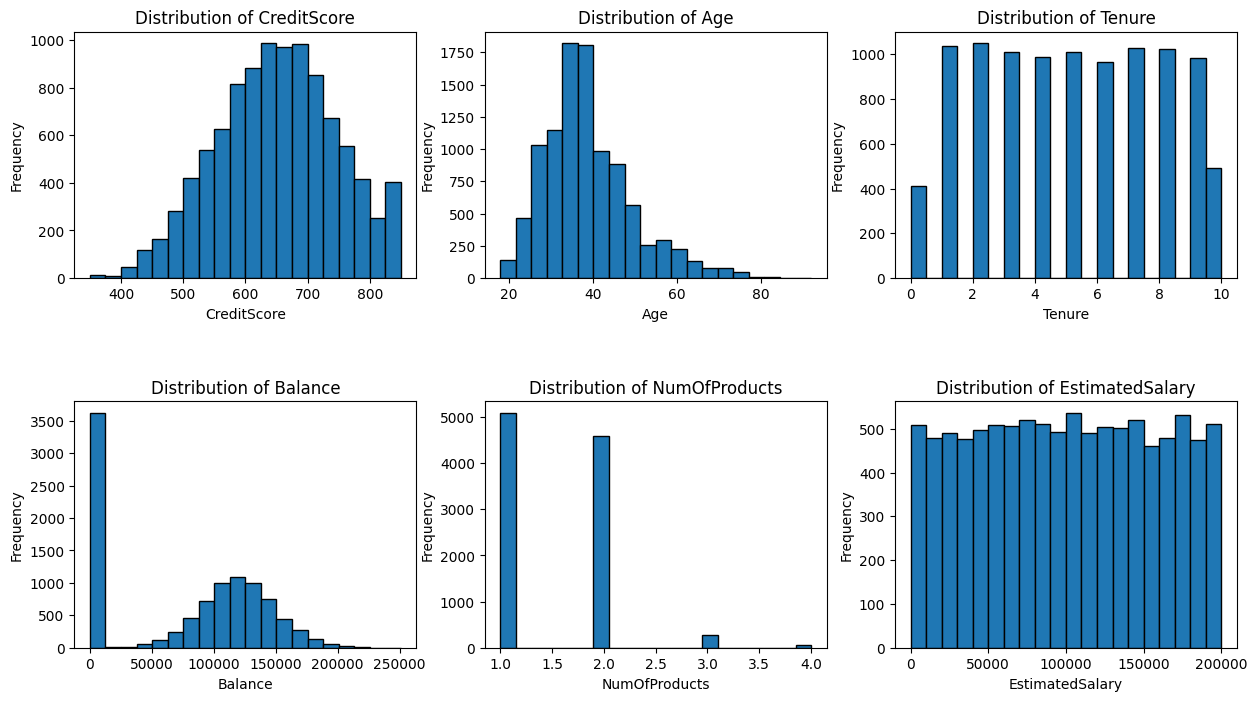

In [324]:
# Define continuous columns and plot distributions
cont_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
plot_continuous_variable_distributions(bank_churn_df, cont_cols)

The distributions of the continuous variables look to be somewhat normal for `CreditScore` and `Distribution of Age`. The distribution of `Balance` looks perfectly normal besides at the 0 where there is a frequency of over 3500 customers who have a bank balance of $0 (we will standardize this variable to be centered around 0 later). Additionally, most customers seem to have either 1 or 2 for `NumOfProducts` while `EstimatedSalary` and `Tenure` appear mostly evenly distributed.

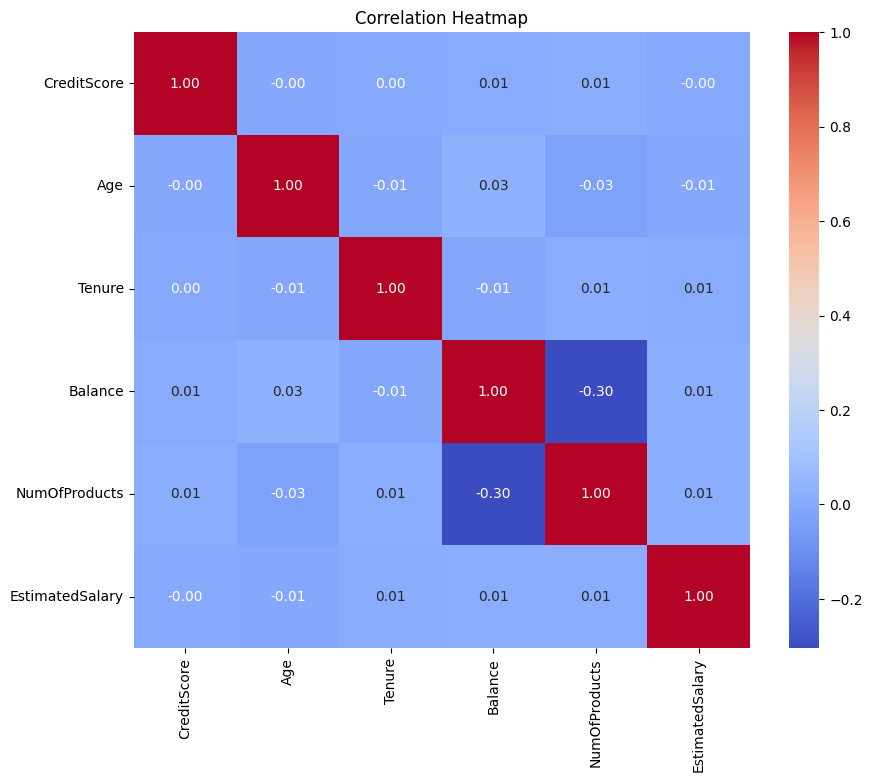

In [325]:
# Compute the correlation matrix for continuous variables
corr_matrix = bank_churn_df[cont_cols].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap')
plt.show()

The highest correlation we have throughout all continuous variables is 0.03 between `Age` and `Balance` (makes sense because older people have more time to accumulate capital). However, there is a relatively strong negative correlation of -0.30 between `Balance` and `NumOfProducts`. This means that the more banking products (like checkings/ savings accounts, mortgagaes, personal loans, Certifcate of Deposits (CDs)) a cusotmer has, the lower the balance is going to be for any of those given accounts. Intuitively, this makes sense because odds are against the average individual to have multiple products with a bank with large balances.

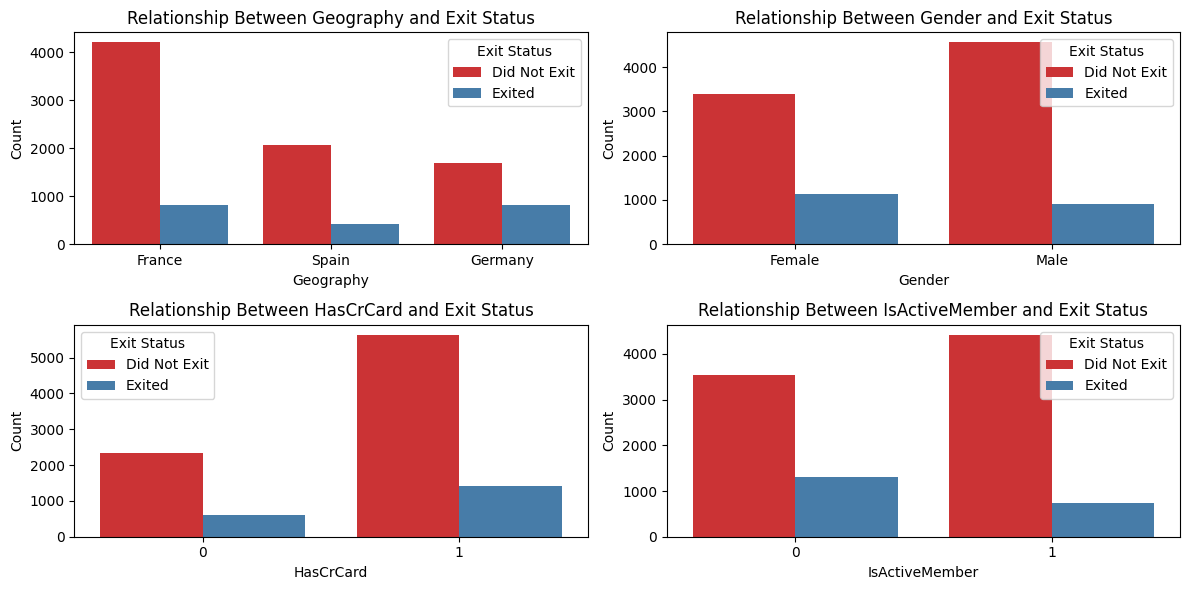

In [326]:
# Define categorical columns
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

# Create bar plots
plt.figure(figsize=(12, 6))
for i, feature in enumerate(cat_cols, start=1):
    plt.subplot(2, 2, i)
    sns.countplot(data=bank_churn_df, x=feature, hue='Exited', palette='Set1')
    plt.title(f'Relationship Between {feature} and Exit Status')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Exit Status', labels=['Did Not Exit', 'Exited'])

plt.tight_layout()
plt.show()

Looking at these barplots, we can quickly determine a few different facts from our dataset: (1) The order of countries exiting most to least is Germany, France, and Spain, (2) Women are exiting more than men, (3) Those who have a credit card are exiting more than those who don't, and (4) Inactive members are exiting more than those who are active.

In [327]:
bank_churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Looking at .info(), we can see that there are no null values across are features. Therefore, we do not need to worry about dropping NAs for the preprocessing stage.

Text(0.5, 1.0, 'Exit vs. Non-Exit Value Counts')

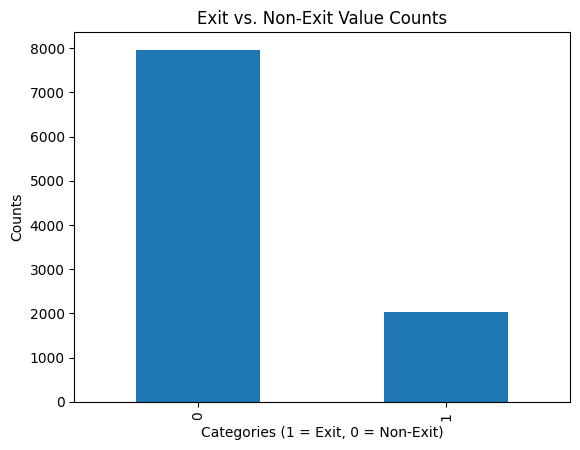

In [328]:
# Count the occurences of exiting vs. non-exiting customers
category_counts = bank_churn_df['Exited'].value_counts()

# Create a bar plot
category_counts.plot(kind = 'bar')

# Add labels and title 
plt.xlabel('Categories (1 = Exit, 0 = Non-Exit)')
plt.ylabel('Counts')
plt.title('Exit vs. Non-Exit Value Counts')

Yikes! This illustration shows that we have far more examples of non-exiting customers than exiting. We need to balance these numbers out if we want to create a non-biased model. To fix this problem, we are going to randomly oversample so that the number of 'Exit' labels equals our 'Non-Exit' labels.

## Preprocessing

Before we do anything, let's make sure that our dataset has equal counts of each label to avoid bias and allow our model generalize better to real-world scenarios.

Text(0.5, 1.0, 'Oversampled Exit vs. Non-Exit Value Counts')

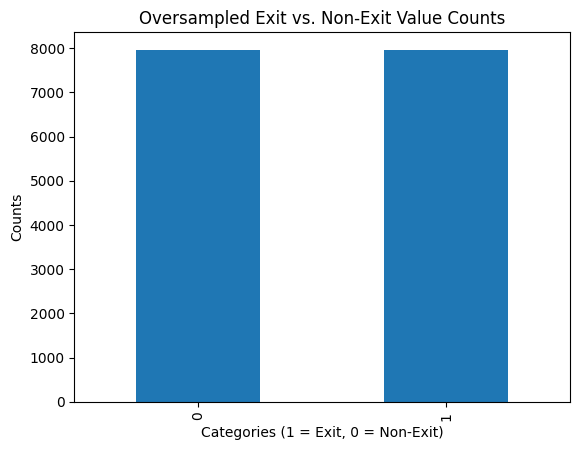

In [329]:
# Shuffle the DataFrame
shuffled_df = bank_churn_df.sample(frac = 1, random_state = 42)

# Oversample the minority class (Exit)
majority_class_size = category_counts.max()
oversampled_df = pd.concat([
    shuffled_df[shuffled_df['Exited'] == 0],
    shuffled_df[shuffled_df['Exited'] == 1].sample(majority_class_size, replace = True)
], axis = 0)

# Display the oversampled barplot
# Create a bar plot
os_category_counts = oversampled_df['Exited'].value_counts()
os_category_counts.plot(kind = 'bar')

# Add labels and title 
plt.xlabel('Categories (1 = Exit, 0 = Non-Exit)')
plt.ylabel('Counts')
plt.title('Oversampled Exit vs. Non-Exit Value Counts')

Much Better! Now let's preprocess our features and make sure they are all in the appropriate format for our Neural Network.

In [330]:
oversampled_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6252,6253,15687492,Anderson,596,Germany,Male,32,3,96709.07,2,0,0,41788.37,0
4684,4685,15736963,Herring,623,France,Male,43,1,0.00,2,1,1,146379.30,0
1731,1732,15721730,Amechi,601,Spain,Female,44,4,0.00,2,1,0,58561.31,0
4742,4743,15762134,Liang,506,Germany,Male,59,8,119152.10,2,1,1,170679.74,0
4521,4522,15648898,Chuang,560,Spain,Female,27,7,124995.98,1,1,1,114669.79,0


Immediately, I recognize that the first three features give us no relevant information regarding whether or not a customer exited. I will remove these columns from the DataFrame.

In [331]:
# Removing unnecessary columns
oversampled_df.drop(labels = ['RowNumber', 'CustomerId', 'Surname'], axis =1, inplace=True)

In [332]:
oversampled_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6252,596,Germany,Male,32,3,96709.07,2,0,0,41788.37,0
4684,623,France,Male,43,1,0.00,2,1,1,146379.30,0
1731,601,Spain,Female,44,4,0.00,2,1,0,58561.31,0
4742,506,Germany,Male,59,8,119152.10,2,1,1,170679.74,0
4521,560,Spain,Female,27,7,124995.98,1,1,1,114669.79,0


In [333]:
# Convert integer-encoded target class labels into a tensor for binary classification
y = oversampled_df['Exited'].values
oversampled_df.drop(labels = 'Exited', axis = 1, inplace = True)

In [334]:
# Use StandardScaler to preprocess continuous variables to be centered around zero
cts_cols = ['CreditScore', 'Age', 'NumOfProducts', 'Tenure', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
oversampled_df[cts_cols] = scaler.fit_transform(oversampled_df[cts_cols])

# Convert categorial variables for input features using one-hot encoding 
encoded_df = pd.get_dummies(oversampled_df, columns = ['Geography', 'Gender'])
bool_cols = encoded_df.columns[11:] 

# Converting categorical columns to binary labels
encoded_df[bool_cols] = encoded_df[bool_cols].astype(np.int64) 
   
# Covnert the DataFrame of predictors into numerical array with dimensions (samples, features)
X = encoded_df.values

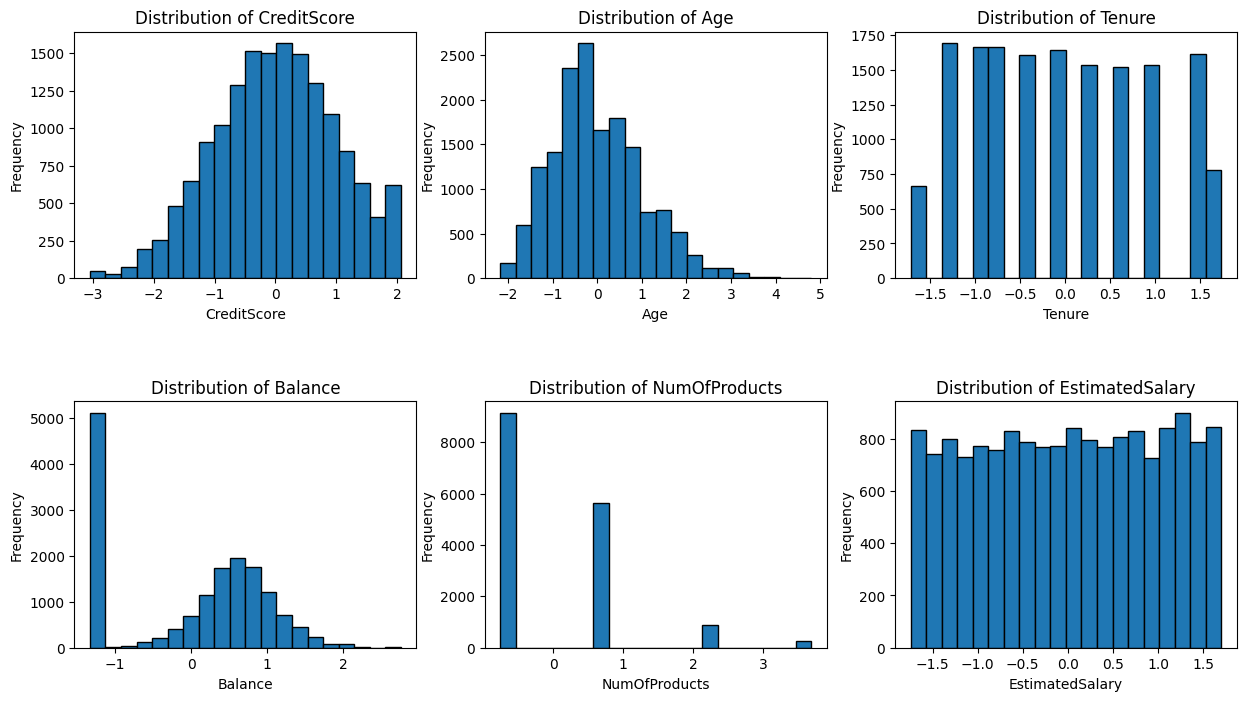

In [335]:
# Define continuous scaled columns and plot distributions
cont_cols_scaled = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
plot_continuous_variable_distributions(oversampled_df, cont_cols_scaled)

Oversampling causes the frequencys to change but does nothing to the underlying distributions of our continuous variables.

## Train Baseline Logistic Regression Model

In [336]:
# Class labels and their order
target_names = ['Non-Exit', 'Exit']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

# Create and train a logistic regression model
logistic_regression = LogisticRegression(random_state=seed_value)
logistic_regression.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_regression.predict(X_test)

# Evaluate the model's performance 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display a classification report with precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:\n", report)

Accuracy: 0.70
Classification Report:
               precision    recall  f1-score   support

    Non-Exit       0.70      0.71      0.71      1605
        Exit       0.70      0.69      0.70      1581

    accuracy                           0.70      3186
   macro avg       0.70      0.70      0.70      3186
weighted avg       0.70      0.70      0.70      3186



This baseline predicts an accuracy of 0.70. This hopefully shouldn't be hard to beat with our neural network. Comparing our baseline model's precision, recall, and f1-score, we see that Non-Exit has the same precision as Exit but it has a higher recall, and f1-score by 0.01. This means that when the model predicts Exit and Non-Exit, it is correct about 70% of the time. Because the recall is slightly higher for Non-Exit, this indicates that our model correctly identifies actual Non-Exits slightly more than actual Exits. Because he recall is slightly higher than precision in Non-Exit than for Exit it makes sense that the f1-socre, the harmonic mean of precision and recall is also slightly higher for Non-Exit.

## Create Neural Network model

It's time to create a way to try different combinations of node sizes and layers starting with 2 layers and 4 different node sizes ranging from 64 to 256 with a step size of 64.

In [337]:
# Convert X and y arrays to tensors
predictors = tf.convert_to_tensor(X, dtype=tf.int64)
target = tf.convert_to_tensor(y) 

In [338]:
num_layers = 3
min_nodes_per_layer = 64
max_nodes_per_layer = 256
node_step_size = 64

In [339]:
node_options = list(range(
    min_nodes_per_layer,
    max_nodes_per_layer + 1,
    node_step_size
))
node_options

[64, 128, 192, 256]

In [340]:
two_layer_possibilities = [node_options, node_options]
two_layer_possibilities

[[64, 128, 192, 256], [64, 128, 192, 256]]

In [341]:
# Get all combinations of nodes between two layers
list(itertools.product(*two_layer_possibilities))

[(64, 64),
 (64, 128),
 (64, 192),
 (64, 256),
 (128, 64),
 (128, 128),
 (128, 192),
 (128, 256),
 (192, 64),
 (192, 128),
 (192, 192),
 (192, 256),
 (256, 64),
 (256, 128),
 (256, 192),
 (256, 256)]

This is all of the combinations of our two layers with 4 different node sizes yielding 4 x 4 = 16 different combinations! Now, let's create a more complex permutation series with our same node sizes but 3 layers instead.

In [342]:
layer_possibilities = [node_options] * num_layers
layer_possibilities

[[64, 128, 192, 256], [64, 128, 192, 256], [64, 128, 192, 256]]

In [343]:
layer_node_permutations = list(itertools.product(*layer_possibilities))
layer_node_permutations

[(64, 64, 64),
 (64, 64, 128),
 (64, 64, 192),
 (64, 64, 256),
 (64, 128, 64),
 (64, 128, 128),
 (64, 128, 192),
 (64, 128, 256),
 (64, 192, 64),
 (64, 192, 128),
 (64, 192, 192),
 (64, 192, 256),
 (64, 256, 64),
 (64, 256, 128),
 (64, 256, 192),
 (64, 256, 256),
 (128, 64, 64),
 (128, 64, 128),
 (128, 64, 192),
 (128, 64, 256),
 (128, 128, 64),
 (128, 128, 128),
 (128, 128, 192),
 (128, 128, 256),
 (128, 192, 64),
 (128, 192, 128),
 (128, 192, 192),
 (128, 192, 256),
 (128, 256, 64),
 (128, 256, 128),
 (128, 256, 192),
 (128, 256, 256),
 (192, 64, 64),
 (192, 64, 128),
 (192, 64, 192),
 (192, 64, 256),
 (192, 128, 64),
 (192, 128, 128),
 (192, 128, 192),
 (192, 128, 256),
 (192, 192, 64),
 (192, 192, 128),
 (192, 192, 192),
 (192, 192, 256),
 (192, 256, 64),
 (192, 256, 128),
 (192, 256, 192),
 (192, 256, 256),
 (256, 64, 64),
 (256, 64, 128),
 (256, 64, 192),
 (256, 64, 256),
 (256, 128, 64),
 (256, 128, 128),
 (256, 128, 192),
 (256, 128, 256),
 (256, 192, 64),
 (256, 192, 128),
 (2

Now that is a lot of permutations. (4 x 4 x 4 = 64 permutations)

In [344]:
for permutation in layer_node_permutations[:2]:
    for nodes_at_layer in permutation:
        print(nodes_at_layer)
    print()

64
64
64

64
64
128



We will use this iteration logic to iterate through each permutation and create a Sequential model with all possible nodes at each layer. In our hidden layers, I will use the ReLU activation function because of its computational efficiency (activation for positive values is the input value and the gradient is either 0 or 1 making backpropogation calculations simpler and faster). I am using the sigmoid activation function for my output layer because of the Output interpretation for our binary classification problem (only maps its input to a range between 0 and 1).

In [345]:
# The input shape to use in the first hidden layer
n_cols = predictors.shape[1]
input_shape = (n_cols,)

models = []

for permutation in layer_node_permutations:
    model = Sequential()
    model.add((InputLayer(input_shape=input_shape)))
    model_name = ''

    for nodes_at_layers in permutation:
        model.add(Dense(nodes_at_layers, activation = 'relu'))
        model_name += f'dense{nodes_at_layers}_'
    
    model.add(Dense(1, activation = 'sigmoid'))
    model._name = model_name[:-1]

    models.append(model)

In [346]:
models[0].summary()

Model: "dense64_dense64_dense64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16108 (Dense)         (None, 64)                896       
                                                                 
 dense_16109 (Dense)         (None, 64)                4160      
                                                                 
 dense_16110 (Dense)         (None, 64)                4160      
                                                                 
 dense_16111 (Dense)         (None, 1)                 65        
                                                                 
Total params: 9281 (36.25 KB)
Trainable params: 9281 (36.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


This summary of our first model (with three hidden layers containing 64 nodes) displays the type of layer, the output shape and the number of paramters at each layer. The number of parameters refers to the total number of weights and biases associated with each layer, providing insight into the complexity of the model. Too many parameters could lead to overfitting and too few to overfitting.

## Optimization Function

In [347]:
def get_models(num_layers: int,
               min_nodes_per_layer: int,
               max_nodes_per_layer: int,
               node_step_size: int,
               input_shape: tuple,
               hidden_layer_activation: str = 'relu',
               num_nodes_at_output: int = 2,
               output_layer_activation: str = 'softmax') -> list:
    """
    Generate a list of Keras Sequential models.

    Args:
        num_layers (int): Number of hidden layers.
        min_nodes_per_layer (int): Min nodes per layer.
        max_nodes_per_layer (int): Max nodes per layer.
        node_step_size (int): Node step size.
        input_shape (tuple): Input data shape.
        hidden_layer_activation (str, optional): Activation for hidden layers. Default is 'relu'.
        num_nodes_at_output (int, optional): Nodes in output layer. Default is 2.
        output_layer_activation (str, optional): Activation for output layer. Default is 'softmax'.

    Returns:
        list: List of Keras Sequential models.
    """
    
    node_options = list(range(min_nodes_per_layer, max_nodes_per_layer + 1, node_step_size))
    layer_possibilities = [node_options] * num_layers
    layer_node_permutations = list(itertools.product(*layer_possibilities))

    models = []
    for permutation in layer_node_permutations:
        model = Sequential()
        model.add(InputLayer(input_shape=input_shape))
        model_name = ''

        for nodes_at_layer in permutation:
            model.add(Dense(nodes_at_layer, activation = hidden_layer_activation))
            model_name += f'dense{nodes_at_layer}_'

        model.add(Dense(num_nodes_at_output, activation = output_layer_activation))
        model._name = model_name[:-1]
        models.append(model)

    return models

Let's create models with 2 layers, 3 layers, and 4 layers to see what permutations of 64, 128, 192, and 256 nodes for each layer yields the best accuracy.

In [348]:
# The input shape to use in the first hidden layer
n_cols = predictors.shape[1]
input_shape = (n_cols,)

all_models_2_layers = get_models(
    num_layers=2,
    min_nodes_per_layer=64,
    max_nodes_per_layer=256,
    node_step_size=64,
    input_shape=input_shape
)

all_models_3_layers = get_models(
    num_layers=3,
    min_nodes_per_layer=64,
    max_nodes_per_layer=256,
    node_step_size=64,
    input_shape=input_shape
)

all_models_4_layers = get_models(
    num_layers=4,
    min_nodes_per_layer=64,
    max_nodes_per_layer=256,
    node_step_size=64,
    input_shape=input_shape
)

## Training Function

In [360]:
def optimize(models: list,
             predictors: tf.Tensor,
             target: np.array,
             epochs: int = 30,
             verbose: bool = False) -> pd.DataFrame:
    """
    Train and evaluate Keras models using provided data.

    Args:
        models (list): List of Keras Sequential models.
        predictors (tf.Tensor): Input features.
        target (np.array): Target labels.
        epochs (int, optional): Training epochs. Default is 50.
        validation_split (float, optional): Proportion for validation. Default is 0.2.
        verbose (bool, optional): Display training progress. Default is False.

    Returns:
        pd.DataFrame: Model validation accuracies.
    """
    
    results = []

    def train(model: tf.keras.Sequential) -> dict:
        """
        Train a Keras model and return results.

        Args:
            model (tf.keras.Sequential): The Keras model to be trained.

        Returns:
            dict: Dictionary with model name and validation accuracy.
        """
        # Define early_stopping_monitor
        early_stopping_monitor = EarlyStopping(patience=3)

        model.compile(
            loss = 'binary_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy', recall_m, precision_m, f1_score]
        )

        model_training = model.fit(predictors, target, epochs=epochs, validation_split = 0.2, callbacks = [early_stopping_monitor], verbose = verbose)
        
        return {
            'model_name': model.name,
            'validation_accuracy': model_training.history['val_accuracy'][-1],
            'validation_precision': model_training.history['val_precision_m'][-1],
            'validation_recall': model_training.history['val_recall_m'][-1],
            'validation_f1': model_training.history['val_f1_score'][-1]
        }
    
        
    for model in models:
        try:
            print(model.name, end=' ... ')
            res = train(model=model)
            results.append(res)
        except Exception as e:
            print(f'{model.name} --> {str(e)}')

    return pd.DataFrame(results)

Let's fit all model permutations for 2,3 and 4 layers.

In [356]:
%%time

# Run optimize for 2 layer permutations
optimization_results_2_layers = optimize(
    models=all_models_2_layers,
    predictors = predictors,
    target = target
)

dense64_dense64 ... dense64_dense128 ... dense64_dense192 ... dense64_dense256 ... dense128_dense64 ... dense128_dense128 ... dense128_dense192 ... dense128_dense256 ... dense192_dense64 ... dense192_dense128 ... dense192_dense192 ... dense192_dense256 ... dense256_dense64 ... dense256_dense128 ... dense256_dense192 ... dense256_dense256 ... CPU times: total: 29.2 s
Wall time: 2min 53s


In [358]:
%%time

# Run optimize for 3 layer permutations
optimization_results_3_layers = optimize(
    models=all_models_3_layers,
    predictors = predictors,
    target = target
)

dense64_dense64_dense64 ... dense64_dense64_dense128 ... dense64_dense64_dense192 ... dense64_dense64_dense256 ... dense64_dense128_dense64 ... dense64_dense128_dense128 ... dense64_dense128_dense192 ... dense64_dense128_dense256 ... dense64_dense192_dense64 ... dense64_dense192_dense128 ... dense64_dense192_dense192 ... dense64_dense192_dense256 ... dense64_dense256_dense64 ... dense64_dense256_dense128 ... dense64_dense256_dense192 ... dense64_dense256_dense256 ... dense128_dense64_dense64 ... dense128_dense64_dense128 ... dense128_dense64_dense192 ... dense128_dense64_dense256 ... dense128_dense128_dense64 ... dense128_dense128_dense128 ... dense128_dense128_dense192 ... dense128_dense128_dense256 ... dense128_dense192_dense64 ... dense128_dense192_dense128 ... dense128_dense192_dense192 ... dense128_dense192_dense256 ... dense128_dense256_dense64 ... dense128_dense256_dense128 ... dense128_dense256_dense192 ... dense128_dense256_dense256 ... dense192_dense64_dense64 ... dense192_de

In [268]:
%%time

# Run optimize for 4 layer permutations
optimization_results_4_layers = optimize(
    models=all_models_4_layers,
    predictors = predictors,
    target = target
)

dense64_dense64_dense64_dense64 ... dense64_dense64_dense64_dense128 ... dense64_dense64_dense64_dense192 ... dense64_dense64_dense64_dense256 ... dense64_dense64_dense128_dense64 ... dense64_dense64_dense128_dense128 ... dense64_dense64_dense128_dense192 ... dense64_dense64_dense128_dense256 ... dense64_dense64_dense192_dense64 ... dense64_dense64_dense192_dense128 ... dense64_dense64_dense192_dense192 ... dense64_dense64_dense192_dense256 ... dense64_dense64_dense256_dense64 ... dense64_dense64_dense256_dense128 ... dense64_dense64_dense256_dense192 ... dense64_dense64_dense256_dense256 ... dense64_dense128_dense64_dense64 ... dense64_dense128_dense64_dense128 ... dense64_dense128_dense64_dense192 ... dense64_dense128_dense64_dense256 ... dense64_dense128_dense128_dense64 ... dense64_dense128_dense128_dense128 ... dense64_dense128_dense128_dense192 ... dense64_dense128_dense128_dense256 ... dense64_dense128_dense192_dense64 ... dense64_dense128_dense192_dense128 ... dense64_dense128_

In [357]:
optimization_results_2_layers.sort_values(by='validation_accuracy', ascending=False).head()

,model_name,validation_accuracy,validation_precision,validation_recall,validation_f1
14,dense256_dense192,0.602950,1.0,0.603472,0.749504
15,dense256_dense256,0.596987,1.0,0.597049,0.744112
7,dense128_dense256,0.596673,1.0,0.596979,0.744051
10,dense192_dense192,0.592279,1.0,0.592847,0.740836
13,dense256_dense128,0.586629,1.0,0.586979,0.736636


In [359]:
optimization_results_3_layers.sort_values(by='validation_accuracy', ascending=False).head()

,model_name,validation_accuracy,validation_precision,validation_recall,validation_f1
60,dense256_dense256_dense64,0.688324,1.0,0.688472,0.813065
59,dense256_dense192_dense256,0.687068,1.0,0.687708,0.812311
56,dense256_dense192_dense64,0.684557,1.0,0.684722,0.810281
44,dense192_dense256_dense64,0.682988,1.0,0.683403,0.809092
61,dense256_dense256_dense128,0.680477,1.0,0.680660,0.807163


In [269]:
optimization_results_4_layers.sort_values(by='validation_accuracy', ascending=False).head()

,model_name,validation_accuracy,validation_precision,validation_recall,validation_f1
238,dense256_dense192_dense256_dense192,0.566541,1.0,0.566493,0.719671
236,dense256_dense192_dense256_dense64,0.564658,1.0,0.564618,0.718095
111,dense128_dense192_dense256_dense256,0.563402,1.0,0.563368,0.716942
125,dense128_dense256_dense256_dense128,0.562775,1.0,0.562257,0.715866
231,dense256_dense192_dense128_dense256,0.561519,1.0,0.561250,0.714792


My Best validation accuracy is ~75% when using a sequential model with 3 hidden layers of size 256, 192, 128, and 192 nodes! Not bad.

In [352]:
# The input shape to use in the first hidden layer
n_cols = predictors.shape[1]
input_shape = (n_cols,)

# Define early_stopping_monitor
#early_stopping_monitor = EarlyStopping(patience=3)

# Create the new model
model = Sequential()

# Add the first, second, and third hidden layers
model.add(Dense(1,input_shape = input_shape))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))


# Add the output layer (use 2 nodes because there are two options - exit and stay)
model.add(Dense(1, activation = 'sigmoid'))

# Compile model
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy', recall_m, precision_m, f1_score])

# Fit model
model_training = model.fit(predictors, target, epochs=15, validation_split = 0.2)#, callbacks = [early_stopping_monitor])

Epoch 1/15
399/399 [==============================] - 1s 1ms/step - loss: 0.6194 - accuracy: 0.6673 - recall_m: 0.2693 - precision_m: 0.5854 - f1_score: 0.3447 - val_loss: 0.7831 - val_accuracy: 0.4451 - val_recall_m: 0.4453 - val_precision_m: 1.0000 - val_f1_score: 0.6115
Epoch 2/15
399/399 [==============================] - 0s 1ms/step - loss: 0.5719 - accuracy: 0.7031 - recall_m: 0.4485 - precision_m: 0.6533 - f1_score: 0.5183 - val_loss: 0.8753 - val_accuracy: 0.4529 - val_recall_m: 0.4529 - val_precision_m: 1.0000 - val_f1_score: 0.6185
Epoch 3/15
399/399 [==============================] - 0s 958us/step - loss: 0.5583 - accuracy: 0.7111 - recall_m: 0.4759 - precision_m: 0.6537 - f1_score: 0.5388 - val_loss: 0.7751 - val_accuracy: 0.5126 - val_recall_m: 0.5123 - val_precision_m: 1.0000 - val_f1_score: 0.6732
Epoch 4/15
399/399 [==============================] - 0s 935us/step - loss: 0.5539 - accuracy: 0.7155 - recall_m: 0.4935 - precision_m: 0.6693 - f1_score: 0.5548 - val_loss: 0.

In [40]:
model_training.history['val_recall_m']

[0.0009374999790452421,
 0.21791666746139526,
 0.42559027671813965,
 0.1950347125530243]

In [27]:
model_training.history['val_f1_score']

[0.5614582896232605,
 0.3006596863269806,
 0.15572915971279144,
 0.3265971839427948]

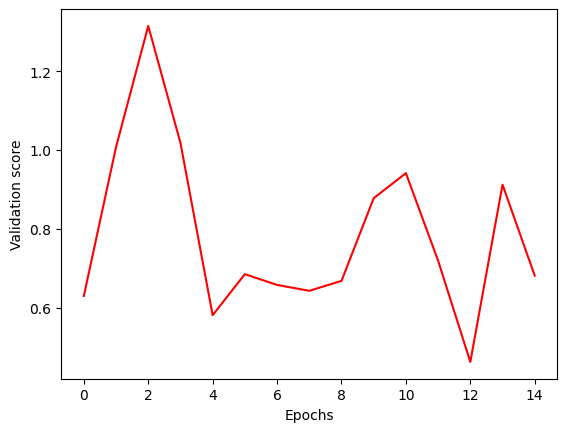

In [102]:
# Create plot of validation loss vs. epochs for model
plt.plot(model_training.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()